In [2]:
import os
import numpy as np
import cantera as ct
import re
from pathlib import Path

In [3]:
gas = ct.Solution('Okafor2018_s59r356.yaml')

In [4]:
Tmin = 500

data_dict = {}
final_list = []

pwd = Path.cwd()
time_directories = [dir for dir in pwd.iterdir() if dir.is_dir()]

key_names = ['T', 'p'] + gas.species_names
key_string = ' '.join(key_names)
print(key_string)


T p H2 H O O2 OH H2O HO2 H2O2 C CH CH2 CH2(S) CH3 CH4 CO CO2 HCO CH2O CH2OH CH3O CH3OH C2H C2H2 C2H3 C2H4 C2H5 C2H6 HCCO CH2CO HCCOH N NH NH2 NH3 NNH NO NO2 N2O HNO CN HCN H2CN HCNN HCNO HOCN HNCO NCO C3H7 C3H8 CH2CHO CH3CHO H2NO N2H2 HONO N2H3 N2H4 NH2OH N2 AR


In [5]:

for time_directory in time_directories:
    for name in key_names:
        file_name = time_directory / name
        with open(file_name, 'r') as file:
            lines = file.readlines()
            
            if 'nonuniform' in lines[19]:
                grid_point_num = int(lines[20])
                
                data_lines = lines[22:22+grid_point_num]
                data = np.array([float(line.strip()) for line in data_lines])
                data_dict[name] = data
                
    list1 = np.array(list(data_dict.values())).T
    list2 = list1[list1[:,0]>Tmin]
    final_list.extend(list2)

final_data = np.array(final_list)
print(final_data.shape)
np.save('2DHIT', final_data)

(0,)


In [6]:
import random
import cantera as ct
import numpy as np

import multiprocessing as mp
from multiprocessing import shared_memory

In [7]:
chem = 'Okafor2018_s59r356.yaml'
gas = ct.Solution(chem)
n_species = gas.n_species
n_process = 50
time_step = 1e-6

def single_step(npstate):
    """
    Perform a single step of the simulation.

    Args:
        npstate (numpy.ndarray): The state of the system as a numpy array. The first element is the temperature (T),
            the second element is the pressure (P), and the remaining elements are the mass fractions of the species (Y).

    Returns:
        list: A list containing the state of the system before and after the step. The first two elements are the
            temperature (T) and pressure (P) before the step, followed by the mass fractions of the species (Y) and the
            partial molar enthalpies divided by the molecular weights after the step.
    """
    gas = ct.Solution(chem)
    T_old, P_old, Y_old = npstate[0], npstate[1], npstate[2:]
    gas.TPY = T_old, P_old, Y_old
    res_1st = [T_old, P_old] + list(gas.Y) + list(gas.partial_molar_enthalpies/gas.molecular_weights)
    r = ct.IdealGasConstPressureReactor(gas, name='R1')
    sim = ct.ReactorNet([r])

    sim.advance(time_step)
    new_TPY = [gas.T, gas.P] + list(gas.Y) + list(gas.partial_molar_enthalpies/gas.molecular_weights)
    res_1st += new_TPY

    return res_1st

In [8]:
test = np.load('3DXJTU.npy')
test = test[np.random.choice(test.shape[0], 10000)]
print(f"Shape of 1D Flame Sample Data:    {test.shape}")
print("="*80)

# ================================================================================


# Single Step Cantera Simulation
# ================================================================================

randomset2 = test.copy()



test_n_rows = test.shape[0]
shm = shared_memory.SharedMemory(create=True, size =8*test_n_rows*(4+4*n_species))
cantera_out = np.ndarray((test.shape[0],4+4*n_species), dtype=np.float64, buffer=shm.buf)
rows_per_process = (test_n_rows + n_process - 1)//n_process

def worker_evolution(ii):
    for i in range(ii*rows_per_process,(ii+1)*rows_per_process):
        cantera_out[i] = np.array((single_step(randomset2[i, :2+n_species])))
        
print("Performing Single Step Cantera Simulation...\n")
pool = mp.Pool(n_process)
for ii in range(n_process):
    pool.apply_async(worker_evolution, (ii,))
pool.close()
pool.join()
print(f"Shape of Sample Data After Single Step Cantera Simulation:    {cantera_out.shape}")

np.save('dataset_hit', cantera_out)

KeyboardInterrupt: 

(186459, 240)
(59,)


/tmp/ipykernel_362/1437595955.py:22: RuntimeWarning: invalid value encountered in log10
  ax.scatter(res_hit[:,0], np.log10(qdot3), s=0.001)#,color='r')


Text(0.5, 1.0, 'Joint distribution of T-Qdot')

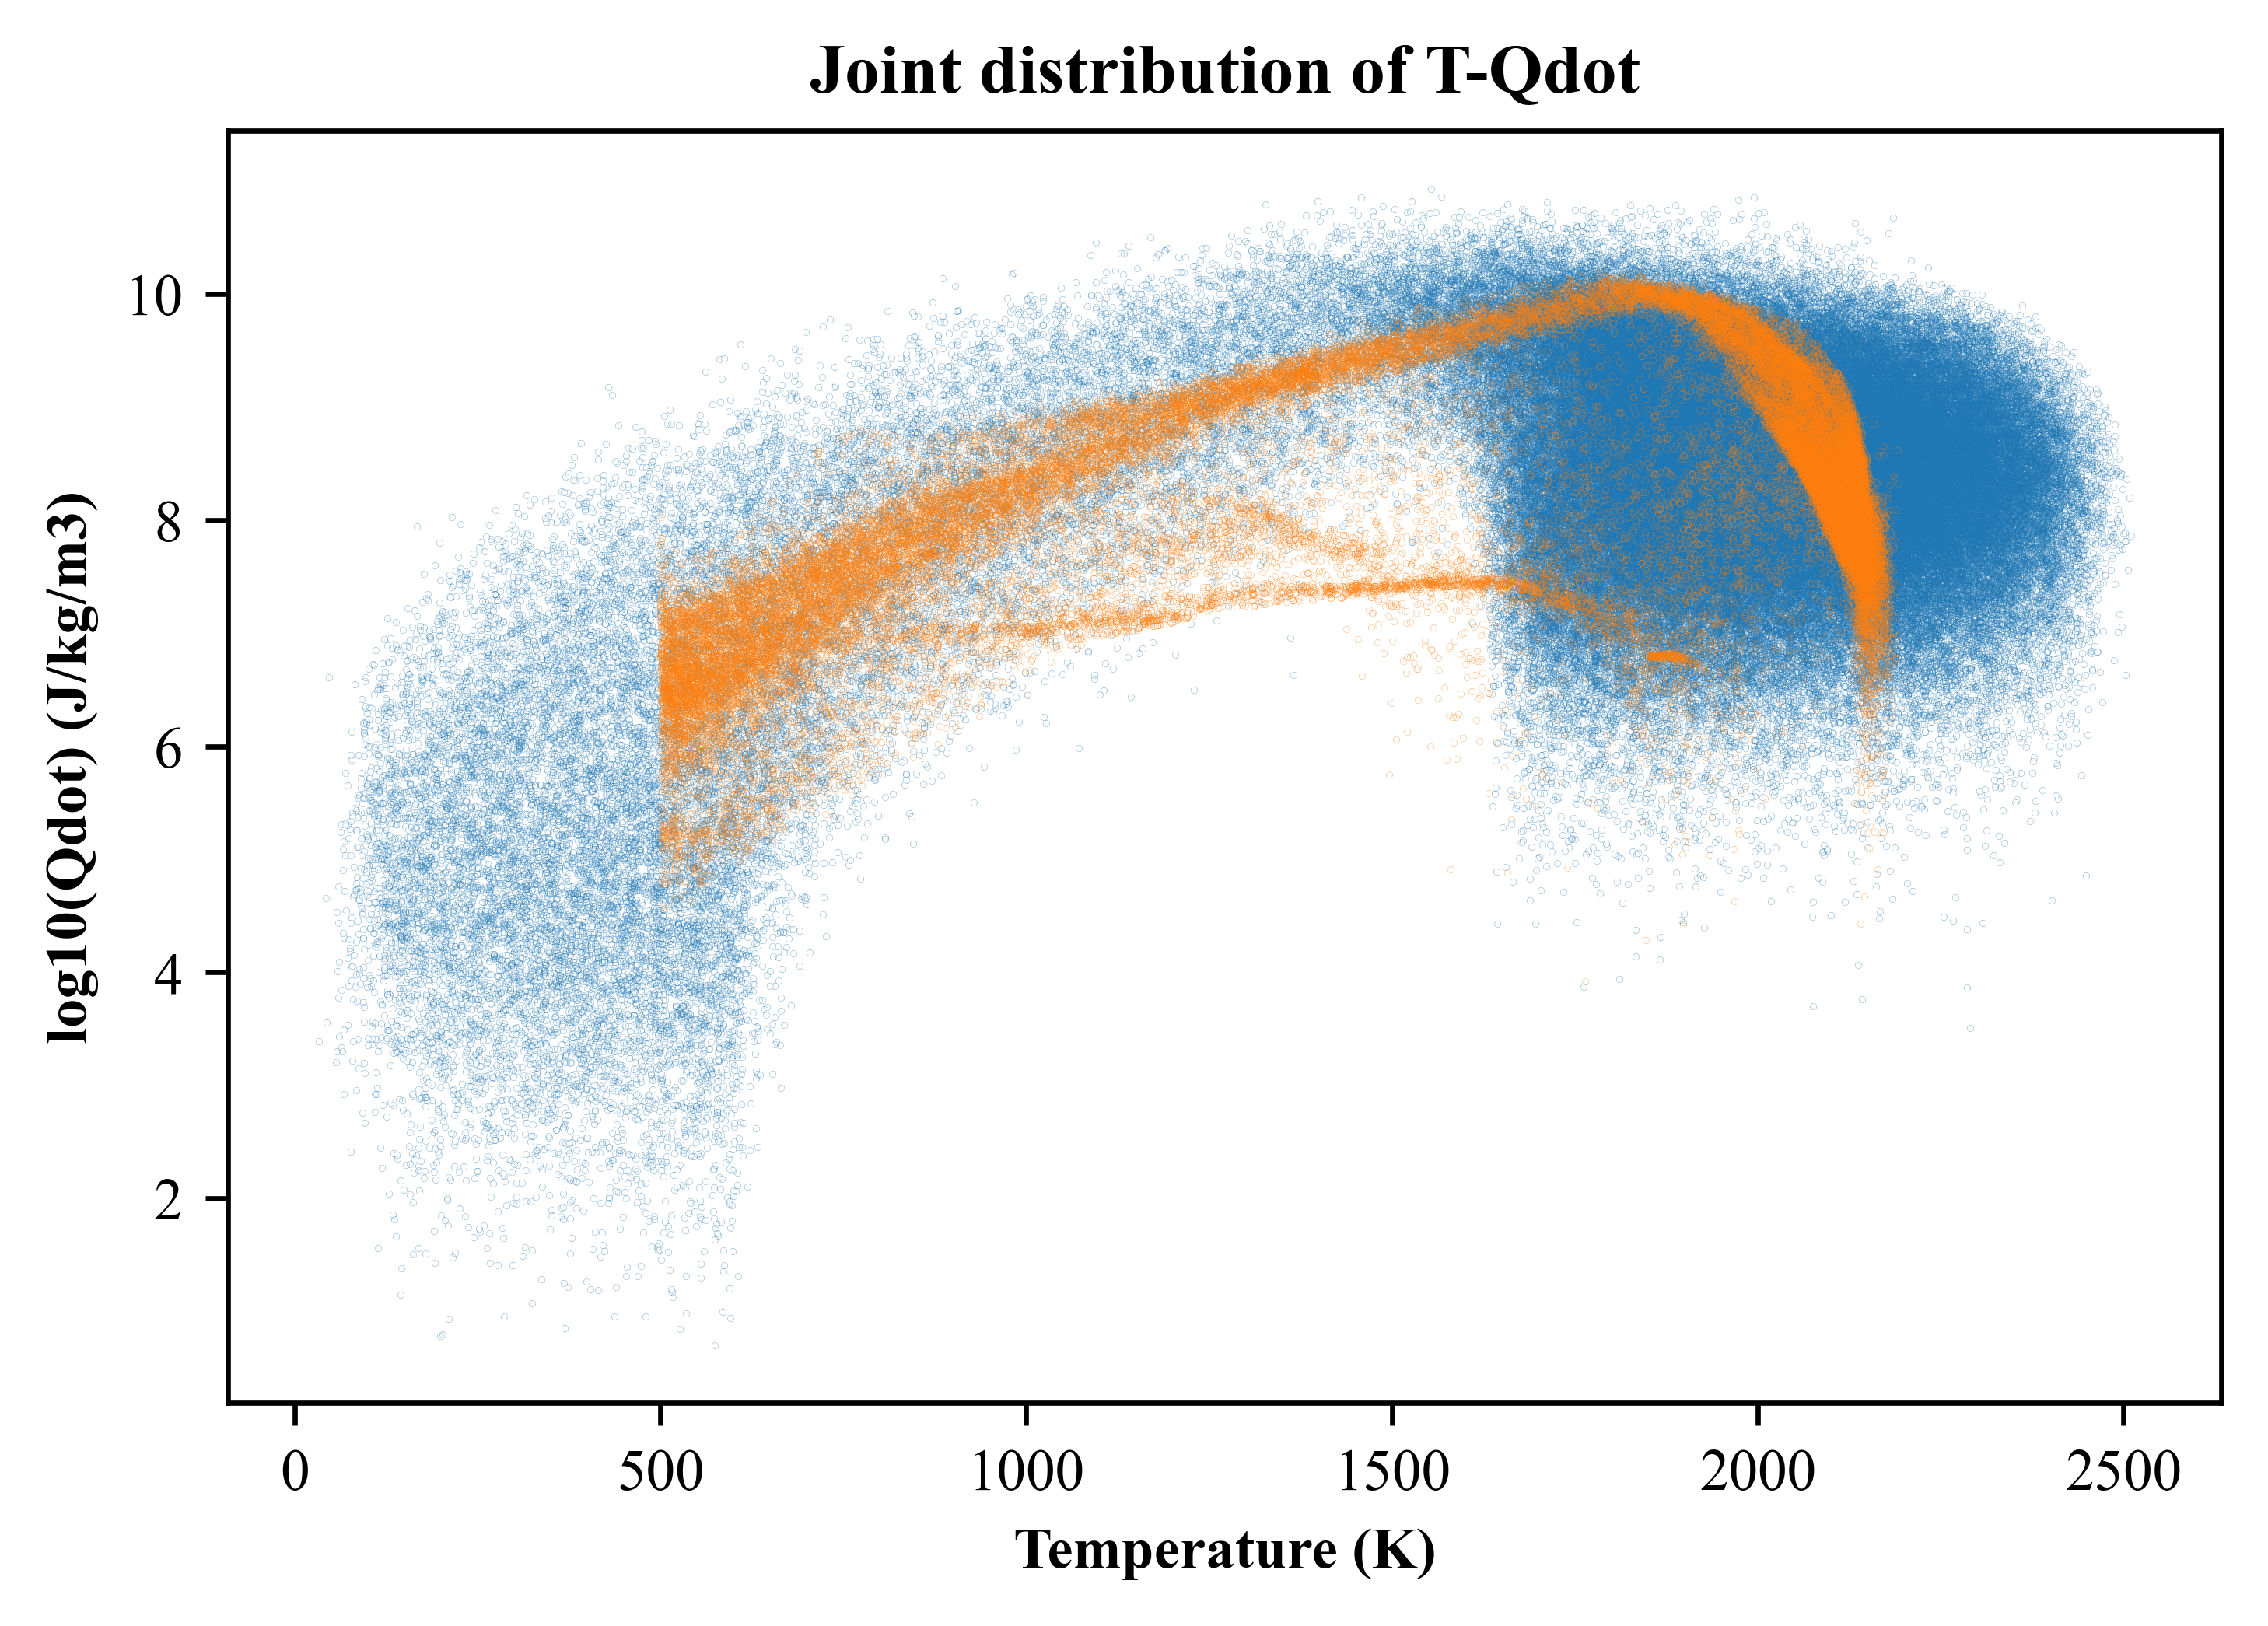

In [9]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 9

res_r = np.load('dataset.npy')
res_hit = np.load('dataset_XJTU.npy')
formation_enthalpies = np.load('formation_enthalpies.npy')
print(res_r.shape)
print(formation_enthalpies.shape)

randomset = res_r

qdot_r = -(formation_enthalpies*(randomset[:,4+2*n_species:4+3*n_species]-randomset[:,2:2+n_species])/1e-6).sum(axis=1)
qdot3 = -(formation_enthalpies*(res_hit[:,4+2*n_species:4+3*n_species]-res_hit[:,2:2+n_species])/1e-6).sum(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(5.512, 3.54), dpi=600)

ax.scatter(randomset[:,0], np.log10(qdot_r), s=0.001)#,color='k')
ax.scatter(res_hit[:,0], np.log10(qdot3), s=0.001)#,color='r')
# ax.ylim((5, 12))
ax.set_xlabel('Temperature (K)',fontweight='bold')
ax.set_ylabel('log10(Qdot) (J/kg/m3)',fontweight='bold')
ax.set_title('Joint distribution of T-Qdot',fontweight='bold')
# plt.legend()

(1269, 240)


Text(0, 0.5, 'CH4')

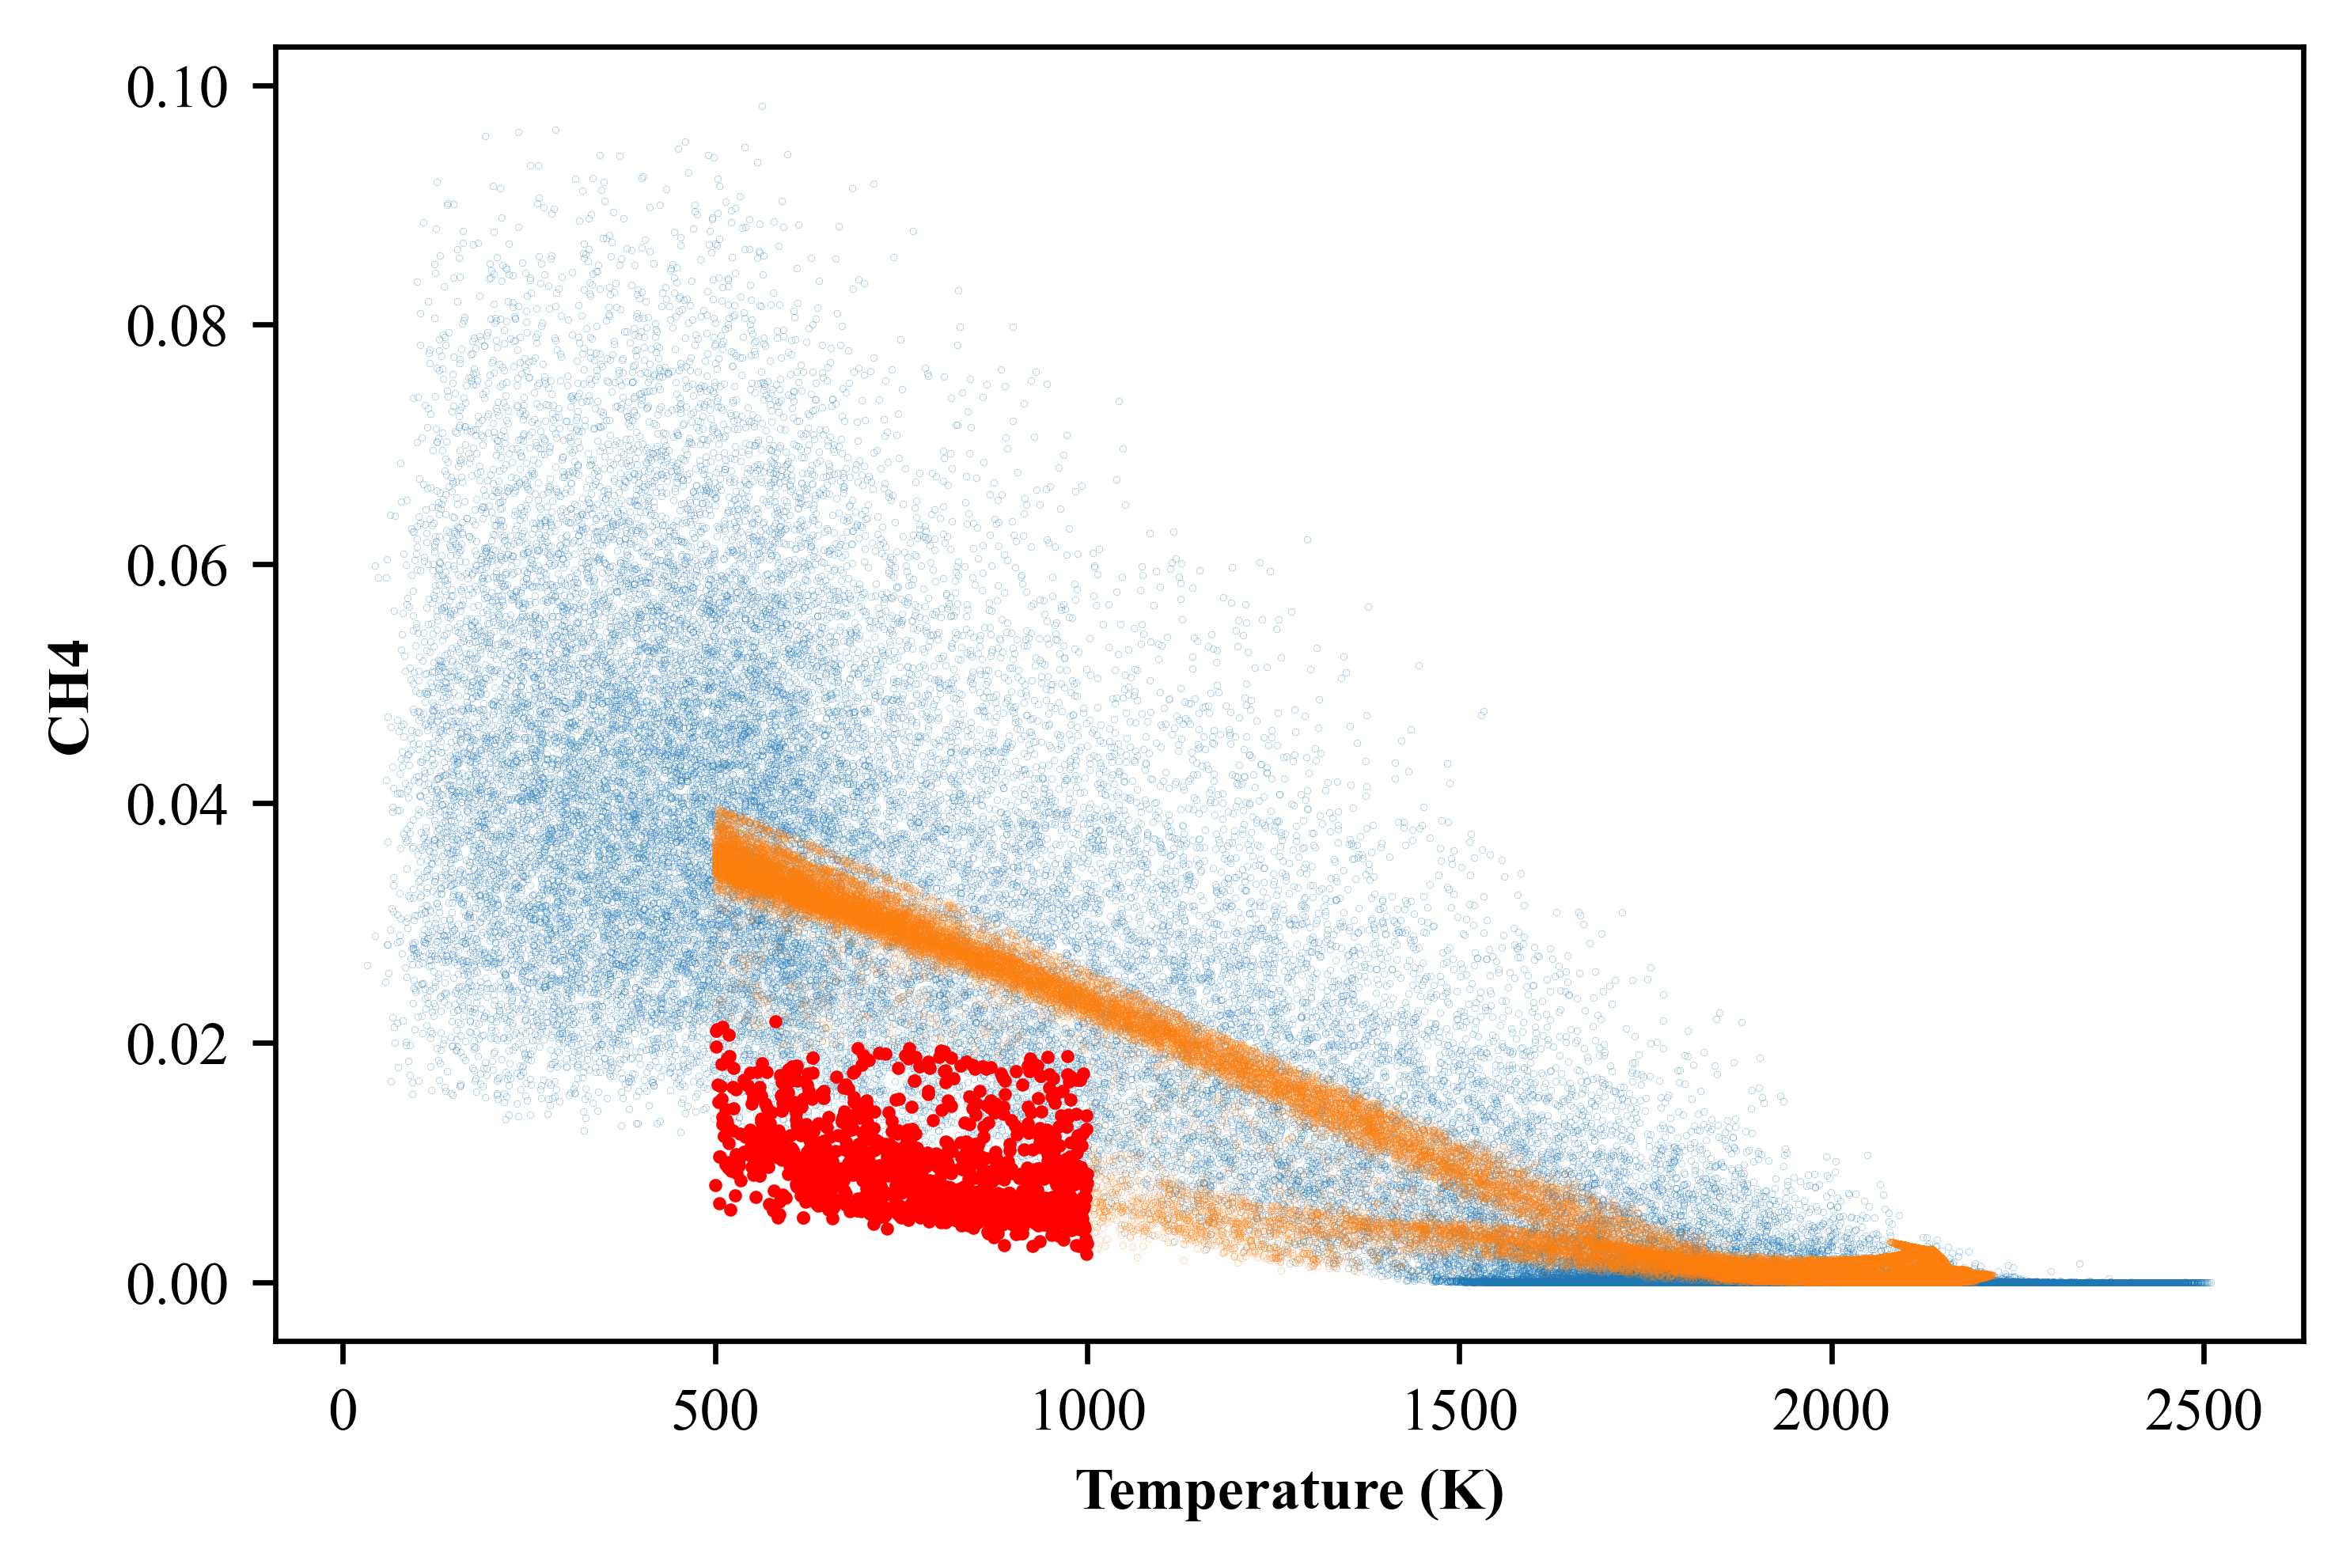

In [32]:
species_name = 'CH4'
index = key_names.index(species_name)

fig, ax = plt.subplots(1, 1, figsize=(5.512, 3.54), dpi=600)

# Condition 1: values in first column < 0.1  
cond1 = res_hit[:,key_names.index('O2')] < 0.1

# Condition 2: values between 500-1000
cond2 = (res_hit[:,0] > 500) & (res_hit[:,0] < 1000) 

# # Combine conditions with & 
select = cond1 & cond2
# select = cond1

# Index array with boolean mask
selected = res_hit[select]
print(selected.shape)

ax.scatter(randomset[:,0], randomset[:,index], s=0.001)#,color='k')
ax.scatter(res_hit[:,0], res_hit[:,index], s=0.001)#,color='r')
ax.scatter(selected[:,0], selected[:,index], s=1,color='r')
# ax.ylim((5, 12))
ax.set_xlabel('Temperature (K)',fontweight='bold')
ax.set_ylabel(species_name,fontweight='bold')
# ax.set_title('Joint distribution of T-Qdot',fontweight='bold')
# plt.legend()